In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!cp /content/drive/My\ Drive/giraffe/root_no_reflection.zip root_no_reflection.zip
!unzip root_no_reflection.zip > ziplog.txt


replace root/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import torch
from torch import nn
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms
from torch.autograd import Variable
import torchvision
from torchvision.datasets import ImageFolder
import numpy as np
from PIL import Image

In [0]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 6, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
import os

transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [0]:
b_size = 128
img_size = 128

train_dataset = ImageFolder('root_no_reflection', transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=b_size, shuffle=True, num_workers=4,
)

num_epochs = 500
learning_rate = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = autoencoder()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, 
    weight_decay=1e-5
)


epoch [1/500], loss:0.2082
epoch [11/500], loss:0.0707
epoch [21/500], loss:0.0489
epoch [31/500], loss:0.0514
epoch [41/500], loss:0.0486
epoch [51/500], loss:0.0457
epoch [61/500], loss:0.0390
epoch [71/500], loss:0.0412
epoch [81/500], loss:0.0397
epoch [91/500], loss:0.0404
epoch [101/500], loss:0.0409
epoch [111/500], loss:0.0475
epoch [121/500], loss:0.0384
epoch [131/500], loss:0.0370
epoch [141/500], loss:0.0363
epoch [151/500], loss:0.0425
epoch [161/500], loss:0.0354
epoch [171/500], loss:0.0442
epoch [181/500], loss:0.0326
epoch [191/500], loss:0.0373
epoch [201/500], loss:0.0349
epoch [211/500], loss:0.0340
epoch [221/500], loss:0.0374
epoch [231/500], loss:0.0428
epoch [241/500], loss:0.0383
epoch [251/500], loss:0.0386
epoch [261/500], loss:0.0384
epoch [271/500], loss:0.0330
epoch [281/500], loss:0.0371
epoch [291/500], loss:0.0388
epoch [301/500], loss:0.0414
epoch [311/500], loss:0.0398
epoch [321/500], loss:0.0428
epoch [331/500], loss:0.0384
epoch [341/500], loss:0.0

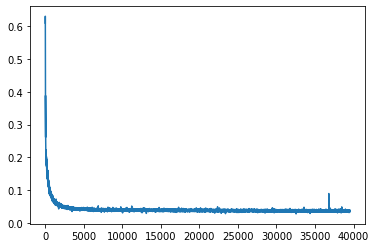

In [15]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, img_size, img_size)
    return x

from torchvision.utils import save_image

# model.load_state_dict(torch.load('/content/drive/My Drive/giraffe/train/checkpoint.pth'))

losses = []
for epoch in range(num_epochs):
    for data, _ in train_loader:

        data = data.view(data.size(0), 3, img_size, img_size)
        data = Variable(data).to(device)

        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output, data)
        losses.append(loss)

        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data))
        pic = to_img(output.cpu().data)
        save_image(pic, '/content/drive/My Drive/giraffe/train/{}.png'.format(str(epoch+1)))
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()
torch.save(model.state_dict(), '/content/drive/My Drive/giraffe/train/checkpoint.pth')